In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### Path class : representation of an individual

In [2]:
class Path:
    '''class to represents a path as a binary string 
    The path goes from the starting point (0,0) to the end point (n-1,n-1)
    
    Attributes:
        'n' (int) : size of the grid
        'bina' (np.array, size= 1 + (n-1)*( 2 + 1 + 1 + int(np.log(n)/np.log(2)) )) : binary representation of the path
        'occ' (np.array, shape=(n,n)) : occupancy grid ; occ[i,j] = 0 if free of obstacle, 1 otherwise

        'n_cell' (int) : number of cells crossed in the path       
        'points' ( (2D np.array) list ) : list of points on the path
        'types' (int list, len = n_cell) : types[i] = 0 if points[i] is an intermediary point of an action, 1 otherwise
        
        'pb' (np.array, size=3) : tell what are the non-valid problems of the path
        'out' (np.array, size=n) : out[i] = 1 if path out-of-bounds at step i, 0 otherwise
        'nCol' (int) : number of collisions with obstacles on the path
    
    Remarks:
        - pb[0] = 0 if path goes out of bound ;  
        - pb[1] = 0 if path doesn't end at the end point ; 
        - pb[2] = 0 if path collides with obstacles
    '''
    
    def __init__ (self, n, occ=np.zeros(0)):
        '''create a random Path instance for a grid of size n
        
        Args: 
            'n' (int) : size of the grid
            'occ' (np.array, shape=(n,n)) : occupancy grid ; occ[i,j] = 0 if free of obstacle, 1 otherwise
        '''
        self.n = n
        
        # useful to visualize paths without occupancy grid
        if occ.size == 0:
            self.occ = np.zeros((self.n, self.n))
        else:
            self.occ = occ
        
        l_code = 1 + int(np.log(n)/np.log(2))       
        self.setBina (np.random.randint(2, size = 1 + (n-1)*(3 + l_code) ) )

    def setBina (self, bina):
        self.bina = bina.copy()
        # check that the path is valid
        self.isValid()
    
    def monotone (self, axis):
        '''convert the Path into a straight line axis-monotone Path
        
        Args:
            'axis' (int, possible={0,1}) : axis of monotony
        '''
        n = self.n
        
        l_code = 1 + int(np.log(n)/np.log(2))
        bina = np.zeros(1 + (n-1)*(3 + l_code), dtype = int)
        
        bina[0] = axis
        
        for i in range(0, n-2):
            # go one cell horizontaly
            bina[1 + i*(3 + l_code):3 + i*(3 + l_code)] = [1,0]
        
        # go all the way up vertically
        bina[1 + 2 + (n-2)*(3 + l_code)] = 1
        m_pad = 1+int(np.log(n)/np.log(2)) - len(bin(n-1)[2:])
        bina[1 + 3 + (n-2)*(3 + l_code):] = np.pad(np.array([int(x) for x in bin(n-1)[2:]]), (m_pad,0), 'constant', constant_values=(0))
        
        self.setBina(bina)
    
    def inBound (self, point):
        '''check if a point from the path is inside the boundaries
        
        Args:
            'point' (int np.array, size = 2) : point from the path
            
        Returns:
            'inBound' (bool) : tells if the point from the path is inside the boundaries
        '''
        
        inBound = (point <= np.array([n-1, n-1])).all() and (point >= np.array([0, 0])).all()
        
        return inBound
    
    def buildPath (self):
        '''build the 'real world' path from the binary representation
        
        Returns:
            'types' (int list, len = n_cell) : types[i] = 0 if points[i] is an intermediary point of an action, 1 otherwise
        '''      
        n = self.n
        
        l_code = 1 + int(np.log(n)/np.log(2))
        
        # store the points on the path
        x0 = np.array([0,0])
        points = [x0]
        x_next = x0

        types = [1]
        
        # axis of monotony
        axis = self.bina[0]
        
        # each monotone path is composed of (n-1) actions
        for i in range(0, n -1):
            action = self.bina[1 + i*(3 + l_code): 1 + (i+1)*(3 + l_code)]
            # movement 
            move = action[0:2]
            
            # compute the next point
            if (move == np.array([0,0])).all(): # vertical
                x_next = x_next + np.array([1, 0])
                points.append(x_next)
                types.append(0)
                
                # direction
                sign = action[2]*2 -1
                # compute the nb of cells crossed
                n_add = action[3:].dot( 2**np.arange(action.size-3) [::-1])
                
                # compute the intermediary points
                for k in range(1, int(n_add)):
                    x_temp = x_next + k*sign*np.array([0, 1])  
                    points.append(x_temp)
                    types.append(0)
                # compute the next point
                x_next = x_next + np.array([0, sign*n_add])               
                points.append(x_next)
                                
            elif (move == np.array([0,1])).all(): # diagonal up
                x_next = x_next + np.array([1, 1])
                points.append(x_next)
            elif (move == np.array([1,0])).all(): # horizontal            
                x_next = x_next + np.array([1, 0])
                points.append(x_next)
            else: # diagonal down
                x_next = x_next + np.array([1, -1])
                points.append(x_next)
            
            types.append(1)

        self.points = np.array(points)
        self.n_cell = len(points)
        # for y-monotone : reverse x and y axis
        if axis:
            self.points = np.fliplr(self.points)
        
        self.types = types
        return types
    
    def isValid (self):
        '''tell if a Path is valid for a given grid by computing the points on the path
        
        Returns:
            'valid' (bool) : tell is the path is valid
        
        Remarks:
            - compute the points that are on the path from the binary np.array
        '''                
        n = self.n
        
        l_code = 1 + int(np.log(n)/np.log(2))
        
        types = self.buildPath()
        
        # store the types of problems
        self.pb = np.ones(3)
        self.out = np.zeros(n)
        self.nCol = 0
        
        i = 0
        # check that the path is collision free
        x_prev = np.array([0,0])
        for (j, x_next) in enumerate(self.points):
            if j == 0:
                continue
                
            i += types[j]  
            # check if x_next is within the boundaries
            test = self.inBound(x_next)

            if not test:
                self.out[i] = max(self.out[i], types[j])
                continue            
            
            # check if x_next is in an obstacle
            self.nCol += self.occ[x_next[1], x_next[0]]
        
        # check that the path stays into the boundaries
        self.pb[0] = (self.out == np.zeros((n,n))).all()
        
        # check that the path ends at the end point
        self.pb[1] = (self.points[-1] == np.array([n-1, n-1])).all()
        
        self.pb[2] = (self.nCol == 0)
        
        valid = self.pb[0] and self.pb[1] and self.pb[2]
        
        return valid
    
    def plot (self, color='blue'):
        '''plot the path on the n*n occupancy grid
        
        Args:
            'color' (String, default='blue') : color of the path plot
        '''
        
        # make a color map of fixed colors
        cmap = mpl.colors.ListedColormap(['white','black'])
        bounds=[0,0.5,1]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        # tell imshow about color map so that only set colors are used
        img = plt.imshow(self.occ, interpolation='nearest', cmap = cmap,norm=norm)

        # make a color bar
        plt.colorbar(img,cmap=cmap, norm=norm,boundaries=bounds)

        # plot the path
        plt.plot(self.points[:,0], self.points[:,1], color=color)
        

In [3]:
def plot_occ (occ):
    '''plot the n*n occupancy grid
    '''

    # make a color map of fixed colors
    cmap = mpl.colors.ListedColormap(['white','black'])
    bounds=[0,0.5,1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # tell imshow about color map so that only set colors are used
    img = plt.imshow(occ, interpolation='nearest', cmap = cmap,norm=norm)

    # make a color bar
    plt.colorbar(img,cmap=cmap, norm=norm,boundaries=bounds)


### Random Map

In [6]:
# Random map
n = 24
occ = np.array([[False, False, False, False,  True, False, False, False, False,
        False, False, False,  True, False,  True, False, False,  True,
        False, False, False,  True,  True, False],
       [False, False, False, False, False, False,  True,  True, False,
         True, False, False,  True,  True,  True, False, False, False,
        False,  True, False, False, False, False],
       [True, False, False,  True, False, False,  True, False,  True,
        False, False,  True, False, False, False, False, False, False,
        False, False, False,  True, False, False],
       [False, False,  True,  True, False, False,  True, False, False,
        False,  True, False, False,  True,  True, False, False, False,
        False,  True, False, False,  True, False],
       [False,  True, False, False, False, False, False,  True, False,
        False, False, False, False,  True, False, False,  True,  True,
        False, False, False, False, False, False],
       [True,  True, False, False, False,  True, False, False, False,
         True,  True, False, False, False, False, False,  True,  True,
        False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False,  True, False, False,  True,  True],
       [False, False, False, False,  True, False, False,  True,  True,
        False,  True,  True, False, False, False, False, False, False,
        False, False,  True, False,  True, False],
       [False,  True, False,  True, False,  True,  True, False, False,
        False, False, False,  True, False, False, False, False,  True,
         True, False,  True,  True, False, False],
       [False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False,  True,  True,  True,
        False, False,  True, False, False,  True],
       [True, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False,  True,  True, False,
        False,  True,  True,  True, False, False],
       [False,  True, False,  True,  True, False, False, False, True,
         True, False, True,  True,  True, False, False, False, False,
        False,  True, False, False,  True,  True],
       [False, False,  True, False, False,  True, False,  True,  True,
        False, False,  True, False,  True, False, False, False, False,       
        True, True, False, False,  True, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False,  True, False,  True, False, False,  True, False,
        False, True, False, False, False,  True],
       [False,  True, False, False, False,  True, False, True,  True,
         True,  True, True, False, False, False,  True, False, False,
         True,  True, False, False, False, False],
       [True, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, True,
         True, False, False, False, False, False],
       [False, False, False, False, False,  True,  True, True, False,
        False, False,  True, False, False,  True, False,  True,  True,
        False, False, False, False,  True, False],
       [True, False,  True,  True, False, False, False,  True, False,
         True, False,  True, False, False, False,  True,  True, False,
         True,  True, False,  True, False, False],
       [False,  True, False, False, False,  True, False, False, False,
        False, False,  True,  True, False,  True,  True, False,  True,
        False,  True, False, False, False, False],
       [False,  True, False, False,  True, False, False, False, False,
         True, False,  True,  True,  True, False, False, False,  True,
        False,  True,  True, False, False,  True],
       [False, False,  True, False,  True, False, False, False,  True,
        False, False, False,  True, False, False, False, False, False,
         True, False,  True, False, False, False],
       [False,  True, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False, False, False,  True,
        False, False, False,  True, False, False],
       [ True, False, False,  True, False,  True,  True,  True,  True,
        False,  True, False, False,  True, False, False, False,  True,
         False, False, False, False, False,  True],
       [False,  True, False,  True, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
        False,  True,  False, False, False, False]], dtype=bool)

In [7]:
bina = np.array([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1])
best_random = Path(n, occ)
best_random.setBina(bina)

In [22]:
bina = np.array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0])
best_ga = Path(n, occ)
best_ga.setBina(bina)

In [9]:
bina = np.array([1, 
       0, 0, 1, 0, 0, 0, 1, 1, 
       0, 1, 1, 0, 0, 1, 0, 0, 
       0, 1, 1, 0, 0, 0, 1, 0, 
       0, 1, 1, 1, 0, 1, 0, 0, 
       0, 1, 1, 0, 0, 0, 0, 1, 
       0, 1, 1, 0, 1, 0, 0, 1, 
       0, 1, 1, 0, 1, 0, 0, 0, 
       0, 1, 1, 0, 1, 0, 0, 0, 
       0, 0, 1, 0, 0, 0, 1, 0, 
       0, 1, 1, 0, 0, 1, 0, 0, 
       0, 1, 0, 1, 0, 1, 0, 1, 
       1, 0, 0, 0, 0, 1, 0, 1, 
       1, 0, 0, 0, 0, 1, 0, 0, 
       1, 0, 1, 1, 1, 0, 0, 0, 
       1, 1, 1, 0, 0, 0, 1, 0, 
       1, 0, 1, 0, 0, 0, 1, 0, 
       1, 0, 1, 0, 1, 0, 1, 0, 
       1, 0, 1, 1, 1, 1, 0, 0, 
       0, 1, 0, 1, 0, 1, 1, 1, 
       0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 
       0, 0, 1, 0, 0, 1, 0, 0, 
       0, 1, 1, 0, 0, 0, 1, 0])
best_astar = Path(n, occ)
best_astar.setBina(bina)

Random best 39 GA best 36 A* best 36


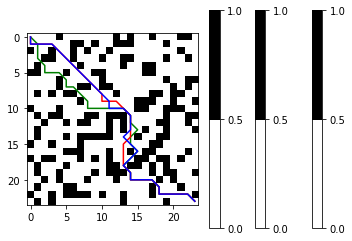

In [23]:
best_random.plot('green')
best_astar.plot('red')
best_ga.plot('blue')

print('Random best', best_random.n_cell, 'GA best', best_ga.n_cell, 'A* best', best_astar.n_cell)


### Narrow valley

In [130]:
occ =np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [131]:
bina = np.array([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0])
best_random = Path(n, occ)
best_random.setBina(bina)

In [132]:
bina = np.array([0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0])
best_ga = Path(n, occ)
best_ga.setBina(bina)

In [133]:
bina = np.array([0, 
       0, 0, 1, 0, 1, 1, 1, 1, 
       0, 1, 1, 0, 0, 1, 0, 0, 
       0, 1, 1, 0, 0, 0, 1, 0, 
       0, 1, 1, 1, 0, 1, 0, 0, 
       0, 1, 1, 0, 0, 0, 0, 1, 
       0, 1, 1, 0, 1, 0, 0, 1, 
       1, 0, 1, 0, 1, 0, 0, 0, 
       1, 0, 1, 0, 1, 0, 0, 0, 
       1, 0, 1, 0, 0, 0, 1, 0, 
       1, 1, 1, 0, 0, 1, 0, 0, 
       1, 0, 0, 1, 0, 1, 0, 1, 
       1, 1, 0, 0, 0, 1, 0, 1, 
       0, 0, 0, 0, 1, 1, 0, 0, 
       1, 1, 0, 1, 1, 0, 0, 0, 
       1, 1, 1, 0, 0, 0, 1, 0, 
       1, 1, 1, 0, 0, 0, 1, 0, 
       1, 1, 1, 0, 1, 0, 1, 0, 
       1, 0, 1, 1, 1, 1, 0, 0, 
       1, 0, 0, 1, 0, 1, 1, 1, 
       0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 
       0, 0, 1, 1, 0, 0, 1, 0, 
       0, 1, 1, 0, 0, 0, 1, 0])
best_astar = Path(n, occ)
best_astar.setBina(bina)

Random best 74 GA best 73 A* best 69


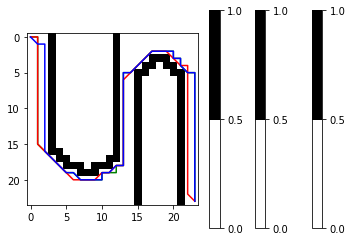

In [134]:
best_random.plot('green')
best_astar.plot('red')
best_ga.plot('blue')

print('Random best', best_random.n_cell, 'GA best', best_ga.n_cell, 'A* best', best_astar.n_cell)


### Maze

In [135]:
occ =np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0],
               [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
               [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
               [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1],
               [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
               [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
               [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
               [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
               [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
               [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
               [1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0],
               [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [136]:
bina = np.array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1])
best_random = Path(n, occ)
best_random.setBina(bina)

In [141]:
bina = np.array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0])
best_ga = Path(n, occ)
best_ga.setBina(bina)

In [138]:
bina = np.array([0, 
       1, 0, 1, 0, 1, 1, 1, 1, 
       1, 0, 1, 0, 0, 1, 0, 0, 
       1, 0, 1, 0, 0, 0, 1, 0, 
       0, 1, 1, 1, 0, 1, 0, 0, 
       0, 1, 1, 0, 0, 0, 0, 1, 
       0, 1, 1, 0, 1, 0, 0, 1, 
       0, 1, 1, 0, 1, 0, 0, 0, 
       0, 1, 1, 0, 1, 0, 0, 0, 
       0, 1, 1, 0, 0, 0, 1, 0, 
       0, 1, 1, 0, 0, 1, 0, 0, 
       0, 0, 1, 0, 0, 1, 0, 0, 
       0, 1, 0, 0, 0, 1, 0, 1, 
       1, 1, 0, 0, 1, 1, 0, 0, 
       1, 1, 0, 1, 1, 0, 0, 0, 
       1, 0, 0, 0, 0, 0, 1, 0, 
       1, 1, 1, 0, 0, 0, 1, 0, 
       1, 1, 1, 0, 1, 0, 1, 0, 
       1, 1, 1, 0, 1, 1, 0, 0, 
       1, 1, 0, 1, 0, 1, 1, 1, 
       0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 
       0, 1, 1, 1, 0, 0, 1, 0, 
       0, 0, 1, 0, 0, 1, 0, 0])
best_astar = Path(n, occ)
best_astar.setBina(bina)

Random best 60 GA best 50 A* best 43


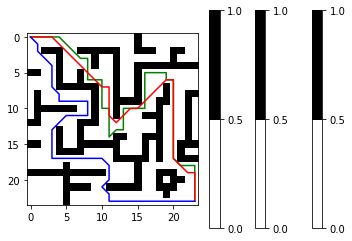

In [142]:
best_random.plot('green')
best_astar.plot('red')
best_ga.plot('blue')

print('Random best', best_random.n_cell, 'GA best', best_ga.n_cell, 'A* best', best_astar.n_cell)
